In [1]:
from typing import List
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import os
import gzip
from tqdm import tqdm

path = "/home/kkumari/PhD/fish-data/long-term-free-swim/"

def load_and_collate_data(all_files: List[str], desired_cols: List[str]) -> dict:
    fish_data = {}
    for file in tqdm(all_files, desc="Processing files"):
        with gzip.open(file, 'rb') as f:
            df = pd.read_csv(f, usecols=desired_cols)
        fish_id = os.path.basename(file)[:2]
        if fish_id not in fish_data:
            fish_data[fish_id] = {'df': [], 'files': []}
        fish_data[fish_id]['df'].append(df)
        fish_data[fish_id]['files'].append(file)
    return fish_data

def calculate_additional_variables(fish_data: dict, fHz: int):
    for fish_id, data in fish_data.items():
        for df in data['df']:
            df["realtime"] = df["realtime"] - df["realtime"].iloc[0]  # Subtract the first timestamp from all timestamps

            zs = df["fishx"].rolling(window=11, center=True).mean().interpolate(method="pad")
            ys = df["fishy"].rolling(window=11, center=True).mean().interpolate(method="pad")
            xs = df["fishz"].rolling(window=11, center=True).mean().interpolate(method="pad")
            dx = xs.diff().interpolate(method='bfill')
            dy = ys.diff().interpolate(method='bfill')
            dz = zs.diff().interpolate(method='bfill')

            df["dx"] = dx
            df["dy"] = dy
            df["dz"] = dz

            angle_wrapped = np.arctan2(dy, dx)
            last = 0
            angles = []
            for phi in angle_wrapped:
                while phi < last - np.pi:
                    phi += 2 * np.pi
                while phi > last + np.pi:
                    phi -= 2 * np.pi
                last = phi
                angles.append(phi)
            
            data['angles'] = angles  # Add this line here

            dt = 1 / fHz
            velocity = np.sqrt(df["dx"] ** 2 + df["dy"] ** 2 + df["dz"] ** 2) / dt
            avg_velocity = velocity.median()# Compute average velocity for each fish
            data['avg_velocity'] = avg_velocity

            height = (0.1, 0.5)
            frames_btw_2bouts = round(fHz / 10)
            bout_width = round(fHz / 100)
            prominence = 0.05
            peaks, _ = find_peaks(velocity, height=height, distance=frames_btw_2bouts, width=bout_width, prominence=prominence)
            angles_at_peaks = [angles[i] for i in peaks]
            data['angles_at_peaks'] = angles_at_peaks
            data['peak_times'] = [df["realtime"].iloc[i] for i in peaks]  # Get the times corresponding to peaks

# Usage
all_files = sorted(glob.glob(os.path.join(path, "*.csv.gz")))
desired_cols = ['fishx', 'fishy', 'fishz', 'realtime']
fish_data = load_and_collate_data(all_files, desired_cols)

calculate_additional_variables(fish_data, fHz=100)


Processing files: 100%|██████████| 59/59 [01:19<00:00,  1.34s/it]


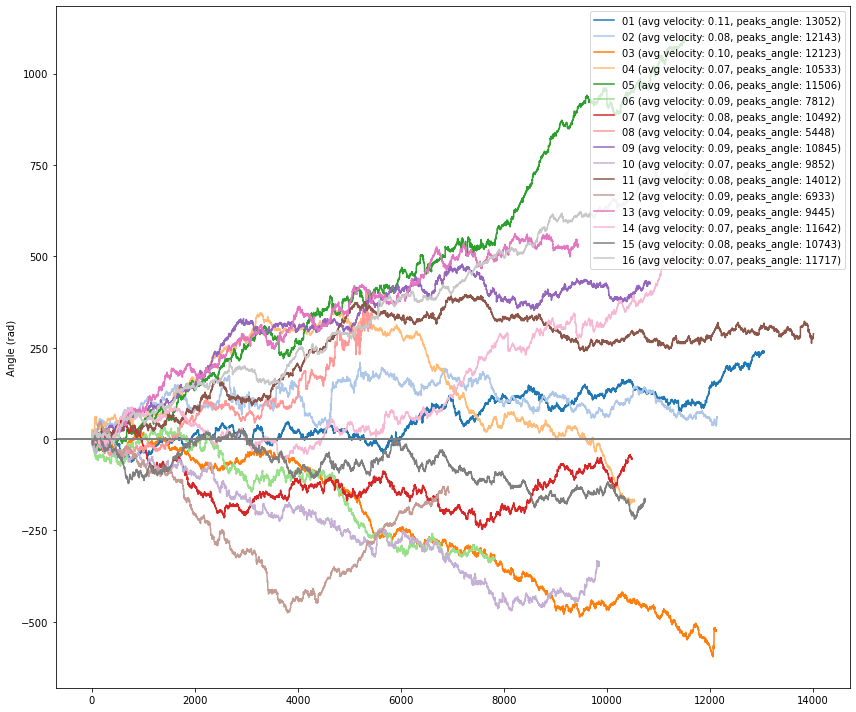

<Figure size 432x288 with 0 Axes>

In [2]:
from matplotlib import pyplot as plt
import matplotlib.cm as cm

def initialize_figure(num_plots: int, figsize: tuple=(12,10)) -> plt.Figure:
    fig, ax = plt.subplots(num_plots, 1, figsize=figsize)
    return fig, ax

def plot_angle_frequency(fish_data: dict, ax: plt.Axes):
    num_colors = 20  # set this to the number of colors you need
    colors = cm.get_cmap('tab20', num_colors)
    for i, (fish_id, data) in enumerate(fish_data.items()):
        ax.plot(data['angles_at_peaks'], color=colors(i), label=f"{fish_id} (avg velocity: {data['avg_velocity']:.2f}, peaks_angle: {len(data['angles_at_peaks'])})")
        ax.axhline(0, color='grey')  # Adds a horizontal line at y=0

    # ax.set_xlabel('Frequency of Angles')  # Set x-axis label
    ax.set_ylabel('Angle (rad)')  # Set y-axis label
    ax.legend(loc='upper right')  # Add legend


def plot_angle_trials(fish_data: dict, axes: plt.Axes):
    for i, (fish_id, data) in enumerate(fish_data.items()):
        axes[i].plot(data['angles'])
        df_lengths = [len(df) for df in data['df']]
        trial_lengths = np.cumsum(df_lengths)
        for trial_length in trial_lengths[:-1]:  # Avoids adding a vertical line at the end of the last trial
            axes[i].axvline(x=trial_length, linestyle='--', color='red')  # Adds a vertical line at the end of each trial

        axes[i].axvline(x=0, linestyle='--', color='red')  # Adds a vertical line at the beginning of the first trial
        axes[i].axhline(0, color='grey')  # Adds a horizontal line at y=0
        axes[i].set_title(fish_id)
        axes[i].set_xlim([0, 2.2e6])  # Set x-axis limits
        axes[i].set_ylim([-2000, 4000])  # Set y-axis limits

def plot_peak_times_vs_angles(fish_data: dict):
    for fish_id, data in fish_data.items():
        plt.figure(figsize=(10, 6))
        plt.plot(data['peak_times'], data['angles_at_peaks'], 'o')
        plt.title(f"Fish {fish_id}")
        plt.xlabel("Time (s)")
        plt.ylabel("Angle at peak (rad)")
        plt.show()
        plt.savefig(f"fish_{fish_id}_peaks.png", dpi=500)


# Usage
fig, ax = initialize_figure(1)
plot_angle_frequency(fish_data, ax)
plt.tight_layout()
plt.show()
plt.savefig("angle_frequency.png", dpi=500)



# fig, axes = initialize_figure(len(fish_data), (10, len(fish_data)*2.5))
# plot_peak_times_vs_angles(fish_data)
# plt.tight_layout()
# plt.show()
# plt.savefig("peak_times_vs_angles.png", dpi=500)

/usr/lib/python3/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


ValueError: setting an array element with a sequence.

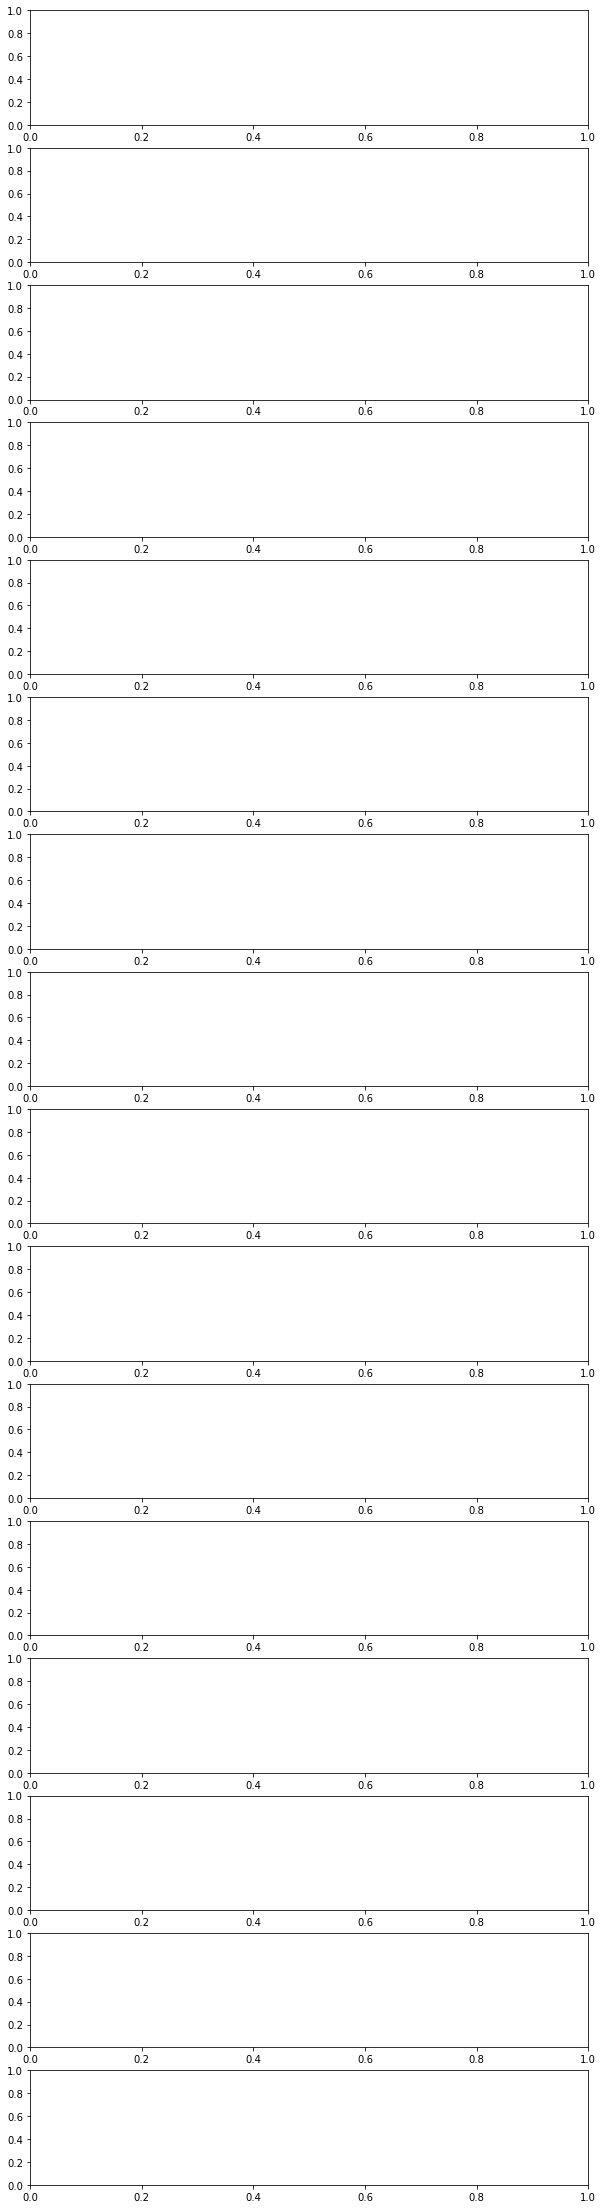

In [10]:
fig, axes = initialize_figure(len(fish_data), (10, len(fish_data)*2.5))
plot_angle_trials(fish_data, axes)
plt.tight_layout()
plt.show()
plt.savefig("angle_trials.png", dpi=500)

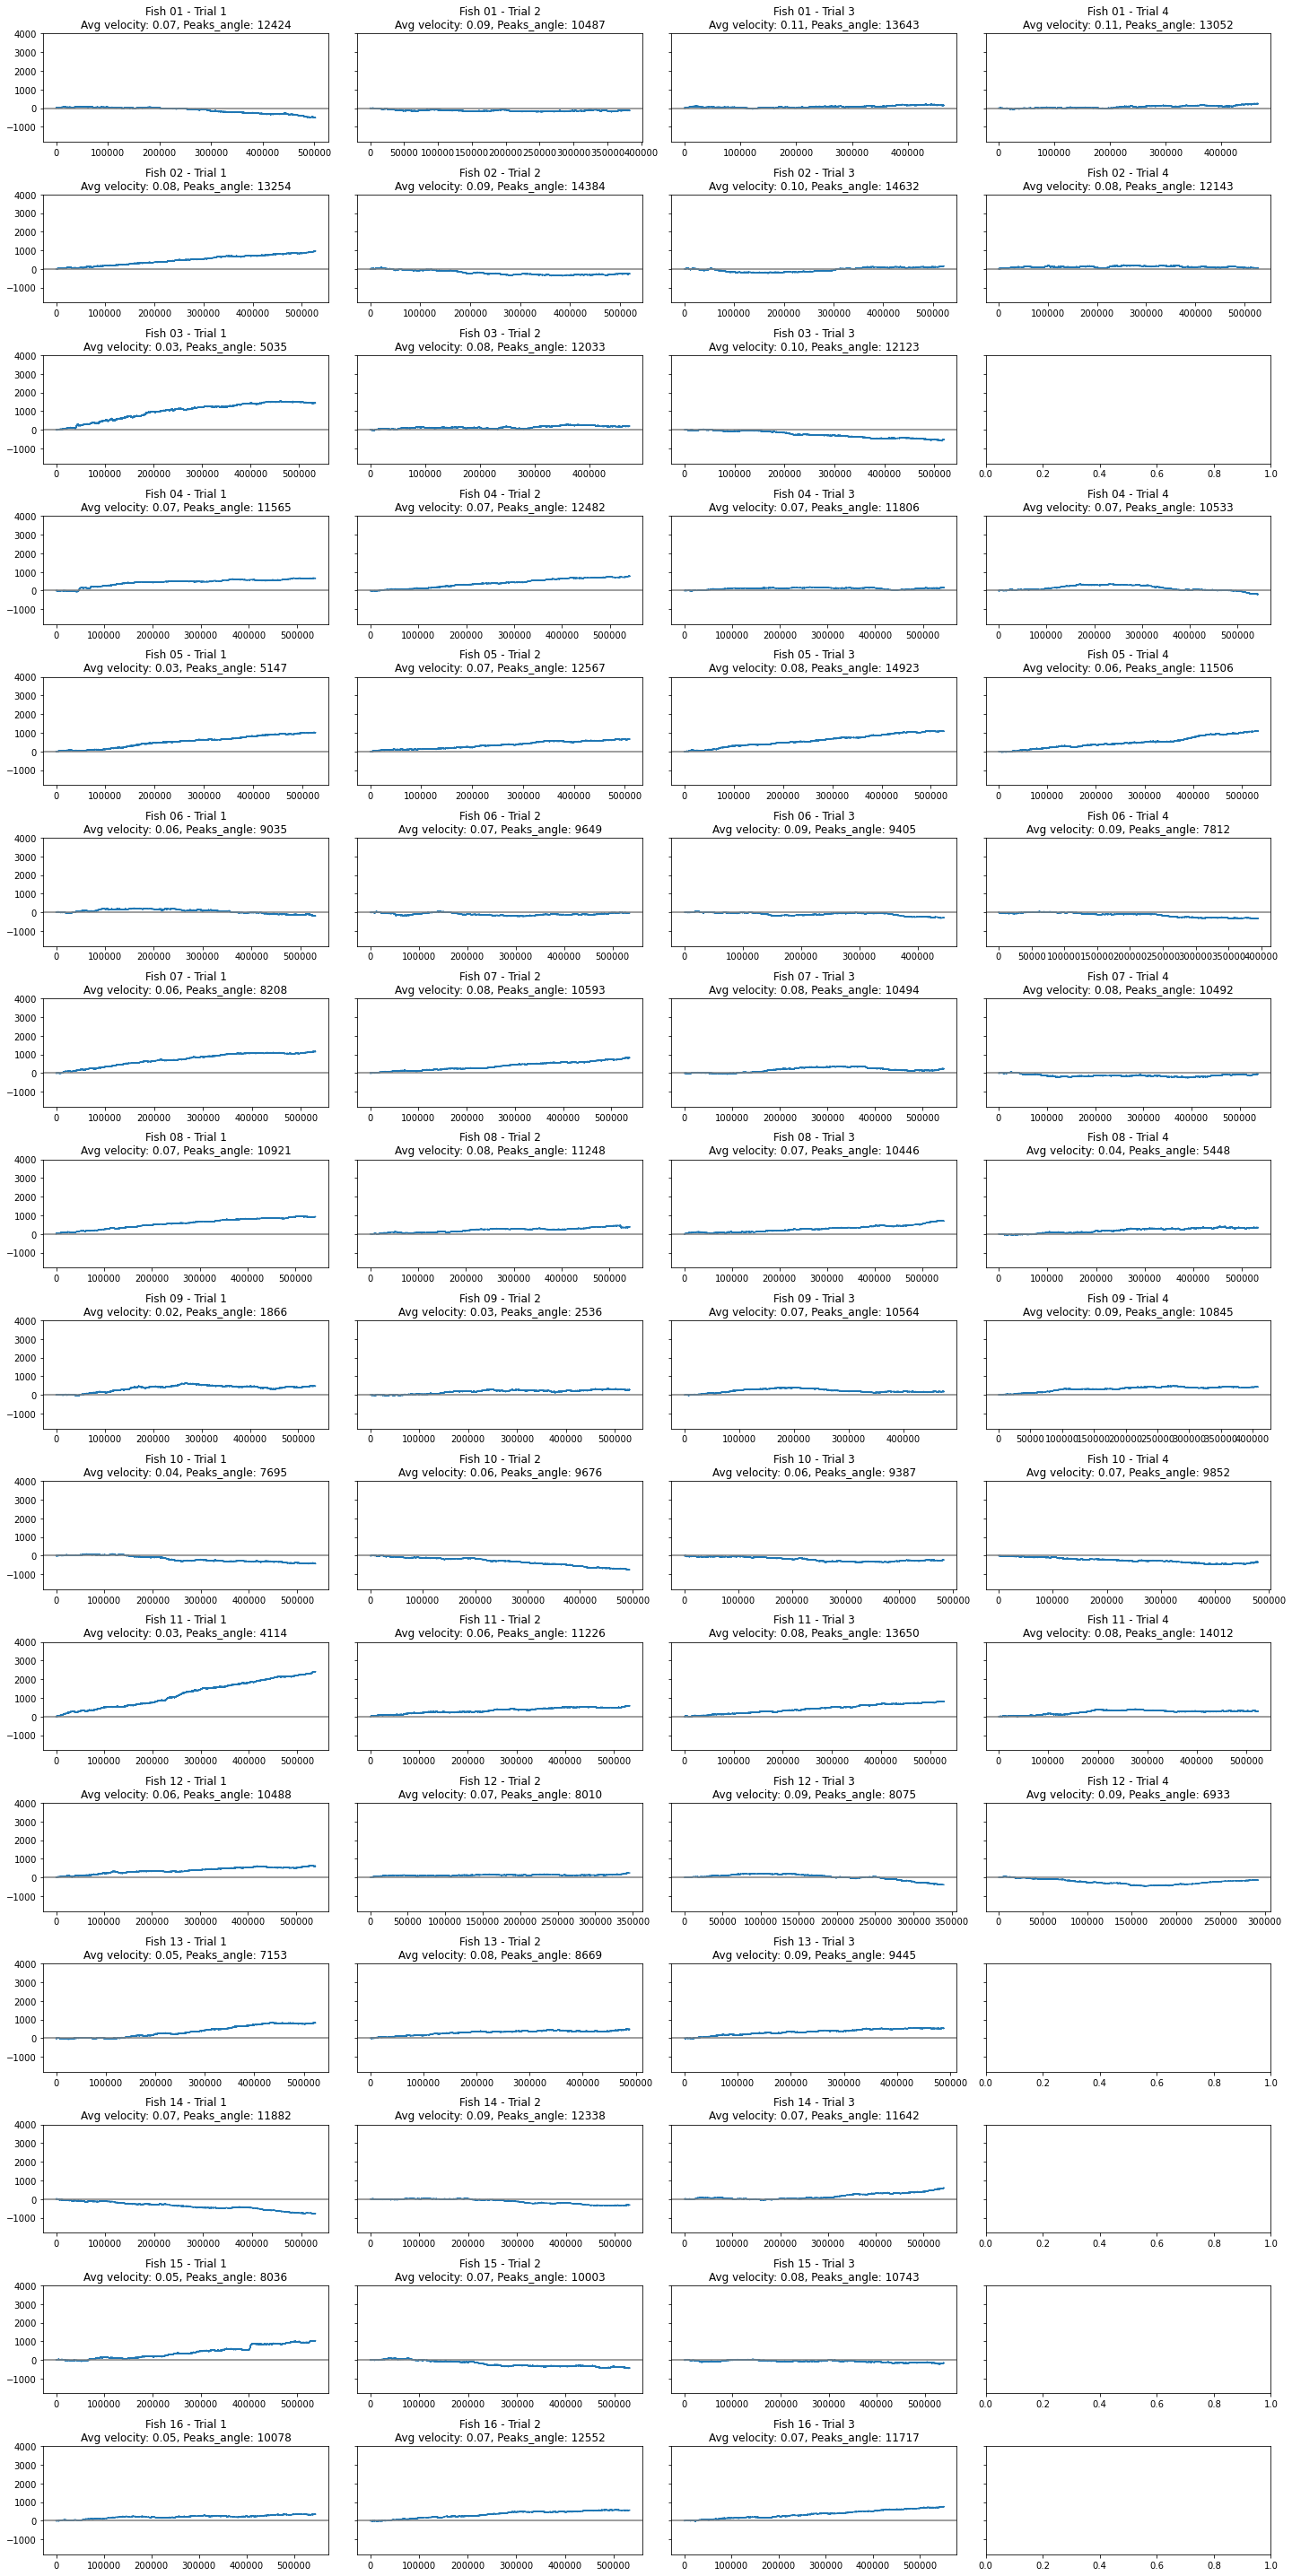

In [3]:
def calculate_additional_variables_per_trial(fish_data: dict, fHz: int):
    for fish_id, data in fish_data.items():
        data['angles'] = []
        data['avg_velocity'] = []
        data['angles_at_peaks'] = []
        for df in data['df']:
            zs = df["fishx"].rolling(window=11, center=True).mean().interpolate(method="pad")
            ys = df["fishy"].rolling(window=11, center=True).mean().interpolate(method="pad")
            xs = df["fishz"].rolling(window=11, center=True).mean().interpolate(method="pad")
            dx = xs.diff().interpolate(method='bfill')
            dy = ys.diff().interpolate(method='bfill')
            dz = zs.diff().interpolate(method='bfill')

            df["dx"] = dx
            df["dy"] = dy
            df["dz"] = dz

            angle_wrapped = np.arctan2(dy, dx)
            last = 0
            angles = []
            for phi in angle_wrapped:
                while phi < last - np.pi:
                    phi += 2 * np.pi
                while phi > last + np.pi:
                    phi -= 2 * np.pi
                last = phi
                angles.append(phi)
            
            data['angles'].append(angles)  # Append each trial's angles to the list

            dt = 1 / fHz
            velocity = np.sqrt(df["dx"] ** 2 + df["dy"] ** 2 + df["dz"] ** 2) / dt
            avg_velocity = velocity.median()# Compute average velocity for each fish
            data['avg_velocity'].append(avg_velocity)

            height = (0.1, 0.5)
            frames_btw_2bouts = round(fHz / 10)
            bout_width = round(fHz / 100)
            prominence = 0.05
            peaks, _ = find_peaks(velocity, height=height, distance=frames_btw_2bouts, width=bout_width, prominence=prominence)
            angles_at_peaks = [angles[i] for i in peaks]
            data['angles_at_peaks'].append(angles_at_peaks)  # Append each trial's peak angles to the list

def plot_angle_trials_per_trial(fish_data: dict, axes: np.ndarray):
    for fish_index, (fish_id, data) in enumerate(fish_data.items()):
        for trial_index, df in enumerate(data['df']):
            # Directly use the pre-calculated angles.
            angles = data['angles'][trial_index]
            avg_velocity = data['avg_velocity'][trial_index]
            angles_at_peaks = len(data['angles_at_peaks'][trial_index])

            axes[fish_index, trial_index].plot(angles)
            axes[fish_index, trial_index].axhline(0, color='grey')  # Adds a horizontal line at y=0
            axes[fish_index, trial_index].set_title(f"Fish {fish_id} - Trial {trial_index+1}\n"
                                                     f"Avg velocity: {avg_velocity:.2f}, Peaks_angle: {angles_at_peaks}")
            axes[fish_index, trial_index].set_ylim([-1800, 4000])  # Set y-axis limits


def initialize_figure_grid(num_rows: int, num_cols: int, figsize: tuple=(20,10)) -> plt.Figure:
    fig, ax = plt.subplots(num_rows, num_cols, figsize=figsize, sharey='row')
    return fig, ax


calculate_additional_variables_per_trial(fish_data, fHz=100)

# # Print out some debug information
# for fish_id, data in fish_data.items():
#     print(f"Fish {fish_id} has {len(data['angles'])} sets of angles.")
#     for trial_index, angles in enumerate(data['angles']):
#         print(f"  Trial {trial_index+1} has {len(angles)} angles.")


num_fish = len(fish_data)
num_trials = max(len(data['df']) for data in fish_data.values())
fig, axes = initialize_figure_grid(num_fish, num_trials, (20, num_fish*2.5))
plot_angle_trials_per_trial(fish_data, axes)
plt.tight_layout()
# plt.show()
plt.savefig("angle_trials_per_trial.png", dpi=500)

In [4]:
def scatter_num_bouts_median_speed(fish_data: dict):
    plt.figure(figsize=(15,12))

    num_trials = max(len(data['angles_at_peaks']) for data in fish_data.values())
    colors = cm.get_cmap('tab10', num_trials)  # Set this to the number of colors needed (one for each trial)
    
    legend_added = [False]*num_trials  # Keep track of which trials already have their legend added

    for fish_id, data in fish_data.items():
        num_bouts = [len(trial) for trial in data['angles_at_peaks']]
        median_speed = data['avg_velocity']
        
        for trial_index in range(len(num_bouts)):
            label = f"Trial {trial_index+1}" if not legend_added[trial_index] else None  # Add label only the first time
            plt.scatter(num_bouts[trial_index], median_speed[trial_index], color=colors(trial_index), label=label)
            legend_added[trial_index] = True  # Mark this trial's legend as added
    
    plt.xlabel('Number of Bouts')
    plt.ylabel('Median Speed')
    plt.legend()
    plt.show()
    plt.savefig("scatter_num_bouts_median_speed.png", dpi=500)  


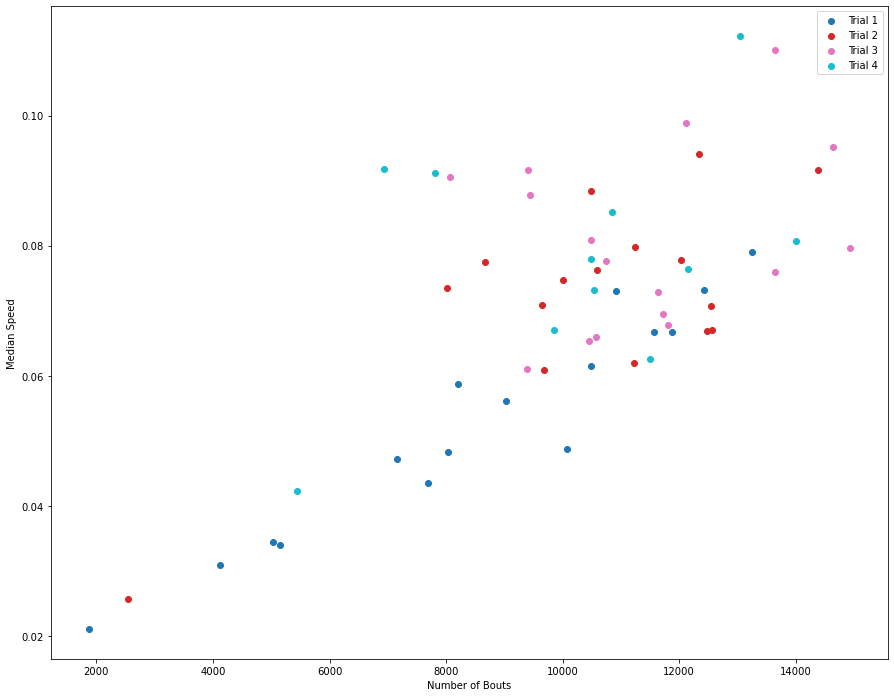

<Figure size 432x288 with 0 Axes>

In [5]:
calculate_additional_variables_per_trial(fish_data, fHz=100)
scatter_num_bouts_median_speed(fish_data)

In [6]:
def scatter_num_bouts_median_speed_by_fish_together(fish_data: dict):
    plt.figure(figsize=(15,12))

    num_fish = len(fish_data)
    colors = cm.get_cmap('tab20', num_fish)  # Set this to the number of colors needed (one for each fish)
    
    legend_added = [False]*num_fish  # Keep track of which fish already have their legend added

    for fish_index, (fish_id, data) in enumerate(fish_data.items()):
        num_bouts = [len(trial) for trial in data['angles_at_peaks']]
        median_speed = data['avg_velocity']
        
        for trial_index in range(len(num_bouts)):
            label = f"Fish {fish_id}" if not legend_added[fish_index] else None  # Add label only the first time
            plt.scatter(num_bouts[trial_index], median_speed[trial_index], color=colors(fish_index), label=label)
            legend_added[fish_index] = True  # Mark this fish's legend as added
    
    plt.xlabel('Number of Bouts')
    plt.ylabel('Median Speed')
    plt.legend()
    # plt.show()
    plt.savefig("scatter_num_bouts_median_speed_by_fish_together.png", dpi=500)


In [19]:
def scatter_num_bouts_median_speed_by_fish_average(fish_data: dict):
    plt.figure(figsize=(15,7))

    num_fish = len(fish_data)
    colors = cm.get_cmap('tab20', num_fish)  # Set this to the number of colors needed (one for each fish)

    for fish_index, (fish_id, data) in enumerate(fish_data.items()):
        # Calculate the average number of bouts across all trials for this fish
        avg_num_bouts = np.mean([len(trial) for trial in data['angles_at_peaks']])
        # Calculate the average of the median speeds across all trials for this fish
        avg_median_speed = np.mean(data['avg_velocity'])

        # Plot the average point for this fish
        plt.scatter(avg_num_bouts, avg_median_speed, color=colors(fish_index), label=f"Fish {fish_id}")
    
    plt.xlabel('Average Number of Bouts')
    plt.ylabel('Average Median Speed')
    plt.legend()
    # plt.savefig("scatter_avg_num_bouts_median_speed_by_fish.png", dpi=500)
    plt.show()


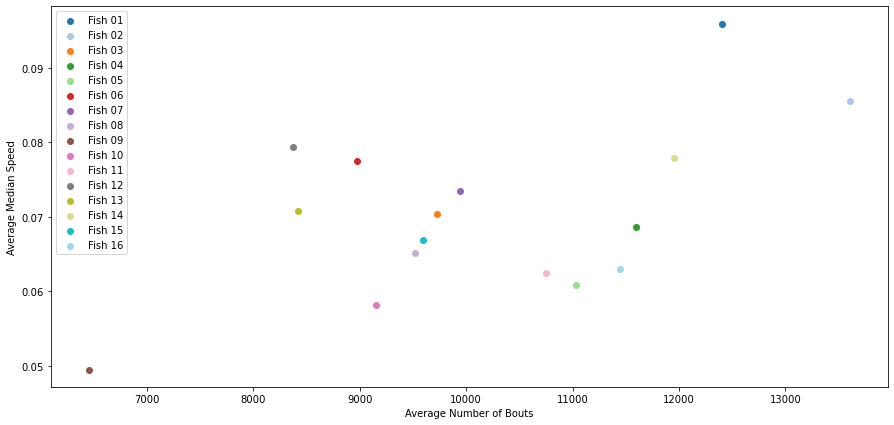

In [20]:
scatter_num_bouts_median_speed_by_fish_average(fish_data)


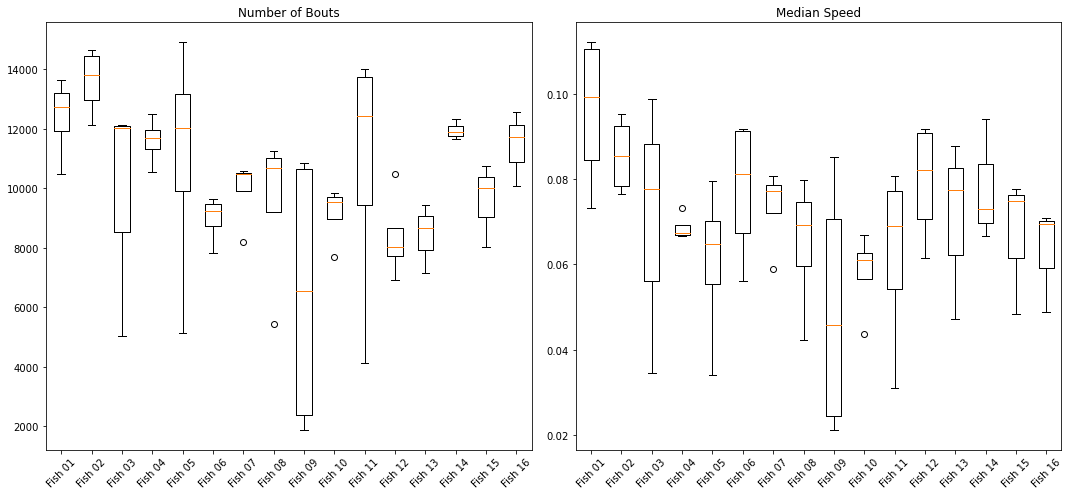

In [22]:
def boxplot_num_bouts_median_speed_by_fish(fish_data: dict):
    fig, axs = plt.subplots(1, 2, figsize=(15,7))

    num_fish = len(fish_data)
    colors = cm.get_cmap('tab20', num_fish)  # Set this to the number of colors needed (one for each fish)

    all_num_bouts = []
    all_median_speeds = []
    labels = []

    for fish_index, (fish_id, data) in enumerate(fish_data.items()):
        # Number of bouts in each trial for this fish
        num_bouts = [len(trial) for trial in data['angles_at_peaks']]
        # Median speed in each trial for this fish
        median_speeds = data['avg_velocity']

        all_num_bouts.append(num_bouts)
        all_median_speeds.append(median_speeds)
        labels.append(f"Fish {fish_id}")

    # Creating box plots
    axs[0].boxplot(all_num_bouts,)
    axs[0].set_title('Number of Bouts')
    axs[0].set_xticklabels(labels, rotation=45)

    axs[1].boxplot(all_median_speeds,)
    axs[1].set_title('Median Speed')
    axs[1].set_xticklabels(labels, rotation=45)

    fig.tight_layout()
    plt.show()
boxplot_num_bouts_median_speed_by_fish(fish_data)

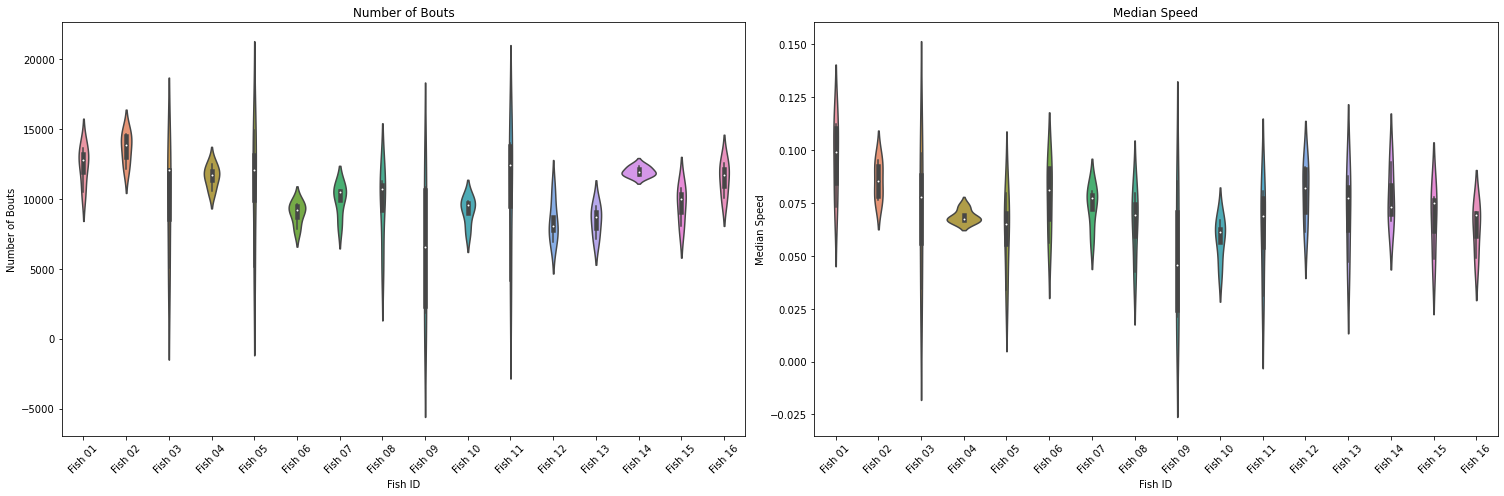

In [34]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def violinplot_num_bouts_median_speed_by_fish(fish_data: dict):
    fig, axs = plt.subplots(1, 2, figsize=(21,7))

    num_fish = len(fish_data)

    all_num_bouts = []
    all_median_speeds = []
    all_labels = []

    for fish_index, (fish_id, data) in enumerate(fish_data.items()):
        # Number of bouts in each trial for this fish
        num_bouts = [len(trial) for trial in data['angles_at_peaks']]
        # Median speed in each trial for this fish
        median_speeds = data['avg_velocity']

        all_num_bouts.extend(num_bouts)
        all_median_speeds.extend(median_speeds)
        all_labels.extend([f"Fish {fish_id}"] * len(num_bouts))

    df = pd.DataFrame({
        'Fish ID': all_labels,
        'Number of Bouts': all_num_bouts,
        'Median Speed': all_median_speeds
    })

    # Creating violin plots
    sns.violinplot(ax=axs[0], x='Fish ID', y='Number of Bouts', data=df)
    axs[0].set_title('Number of Bouts')
    axs[0].tick_params(axis='x', rotation=45)

    sns.violinplot(ax=axs[1], x='Fish ID', y='Median Speed', data=df)
    axs[1].set_title('Median Speed')
    axs[1].tick_params(axis='x', rotation=45)

    fig.tight_layout()
    plt.show()

violinplot_num_bouts_median_speed_by_fish(fish_data)


In [35]:
#  calculate turns and bias per fish
def calculate_turns_per_fish(fish_data: dict):
    turns_per_fish = {}
    for fish_id, data in fish_data.items():
        turns_per_fish[fish_id] = []
        for trial in data['angles_at_peaks']:
            turns_per_fish[fish_id].append(len(trial))
    return turns_per_fish
print(calculate_turns_per_fish(fish_data))

{'01': [12424, 10487, 13643, 13052], '02': [13254, 14384, 14632, 12143], '03': [5035, 12033, 12123], '04': [11565, 12482, 11806, 10533], '05': [5147, 12567, 14923, 11506], '06': [9035, 9649, 9405, 7812], '07': [8208, 10593, 10494, 10492], '08': [10921, 11248, 10446, 5448], '09': [1866, 2536, 10564, 10845], '10': [7695, 9676, 9387, 9852], '11': [4114, 11226, 13650, 14012], '12': [10488, 8010, 8075, 6933], '13': [7153, 8669, 9445], '14': [11882, 12338, 11642], '15': [8036, 10003, 10743], '16': [10078, 12552, 11717]}


In [36]:
# GET THE sign of the turn for each fish and culcuate the left right bias using the sign of the turn
def calculate_bias_per_fish(fish_data: dict):
    bias_per_fish = {}
    for fish_id, data in fish_data.items():
        bias_per_fish[fish_id] = []
        for trial in data['angles_at_peaks']:
            bias_per_fish[fish_id].append(np.mean(trial))
    return bias_per_fish
print(calculate_bias_per_fish(fish_data))

{'01': [-113.1313398668519, -131.45775887012346, 73.95675184277111, 63.120330901953174], '02': [488.32604699805967, -210.59769315669004, -40.977559318204115, 110.52247199476813], '03': [1047.4436167251906, 133.18783390717226, -244.33732824813018], '04': [458.0108965842138, 401.7481930949538, 113.7322772513106, 149.50808446405534], '05': [648.671730888872, 359.50736395697845, 585.8010885104178, 469.5180037582527], '06': [61.129298275039524, -95.27653417270861, -98.49805353823754, -141.45445944614968], '07': [722.2760667308976, 387.95953207593936, 169.6247651133348, -124.25362737154049], '08': [562.7006406223778, 212.93480948634883, 274.64950378111075, 88.95497358784104], '09': [341.30812009684826, 149.05866092829194, 220.52534066419554, 311.30208191120624], '10': [-192.68820375137608, -309.6507416705724, -193.1174960865303, -244.7570220025267], '11': [1416.6013347176563, 337.4699803145711, 421.83461111020864, 241.9210635754183], '12': [382.4128386711138, 119.76226304504871, 24.090981532

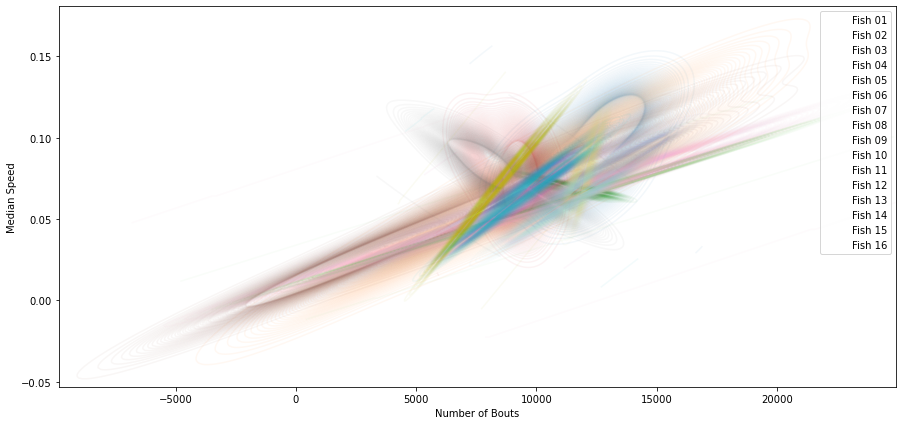

In [31]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def scatter_kde_num_bouts_median_speed_by_fish(fish_data: dict):
    plt.figure(figsize=(15,7))

    num_fish = len(fish_data)
    colors = cm.get_cmap('tab20', num_fish)  # Set this to the number of colors needed

    for fish_index, (fish_id, data) in enumerate(fish_data.items()):
        num_bouts = [len(trial) for trial in data['angles_at_peaks']]
        median_speed = data['avg_velocity']

        # Create a DataFrame for this fish
        df = pd.DataFrame({
            'Number of Bouts': num_bouts,
            'Median Speed': median_speed
        })

        # Plot the 2D KDE for this fish
        sns.kdeplot(x=df['Number of Bouts'], y=df['Median Speed'], color=colors(fish_index), thresh=0, levels=100, label=f"Fish {fish_id}", alpha=0.05)


    plt.xlabel('Number of Bouts')
    plt.ylabel('Median Speed')
    plt.legend([f"Fish {fish_id}" for fish_id in fish_data.keys()])
    plt.show()
scatter_kde_num_bouts_median_speed_by_fish(fish_data)

In [ ]:
bias = {}

# Compute the bias for each fish
for fish_id, fish_turns in turns.items():
    bias[fish_id] = np.mean(fish_turns)

print(bias)

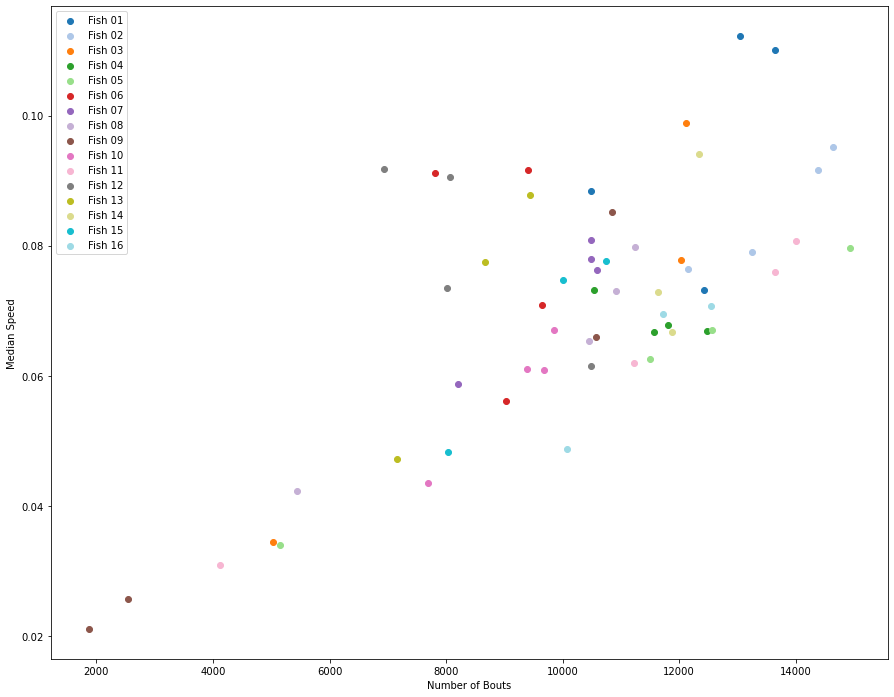

In [7]:
scatter_num_bouts_median_speed_by_fish_together(fish_data)

In [8]:
def scatter_num_bouts_median_speed_by_fish(fish_data: dict):
    num_fish = len(fish_data)
    num_trials = max(len(data['angles_at_peaks']) for data in fish_data.values())
    colors = cm.get_cmap('tab10', num_trials)  # Set this to the number of colors needed (one for each trial)

    # Calculate the number of rows and columns for subplots
    num_cols = 4
    num_rows = num_fish // num_cols if num_fish % num_cols == 0 else num_fish // num_cols + 1

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5*num_rows), sharex=True, sharey=True)

    # Make sure axes is always a 2D array, even when num_fish=1
    if num_fish == 1:
        axes = np.array([axes])

    for fish_index, (fish_id, data) in enumerate(fish_data.items()):
        row = fish_index // num_cols
        col = fish_index % num_cols
        ax = axes[row, col]

        num_bouts = [len(trial) for trial in data['angles_at_peaks']]
        median_speed = data['avg_velocity']
        for trial_index in range(len(num_bouts)):
            ax.scatter(num_bouts[trial_index], median_speed[trial_index], color=colors(trial_index), label=f"Trial {trial_index+1}")

        ax.set_title(f"Fish {fish_id}")
        ax.set_xlabel('Number of Bouts')
        ax.set_ylabel('Median Speed')
        ax.legend()

    # Remove empty subplots
    if num_fish % num_cols != 0:
        for ax in axes[row, col+1:]:
            fig.delaxes(ax)

    plt.tight_layout()
    # plt.show()
    plt.savefig("scatter_num_bouts_median_speed_by_fish.png", dpi=500)


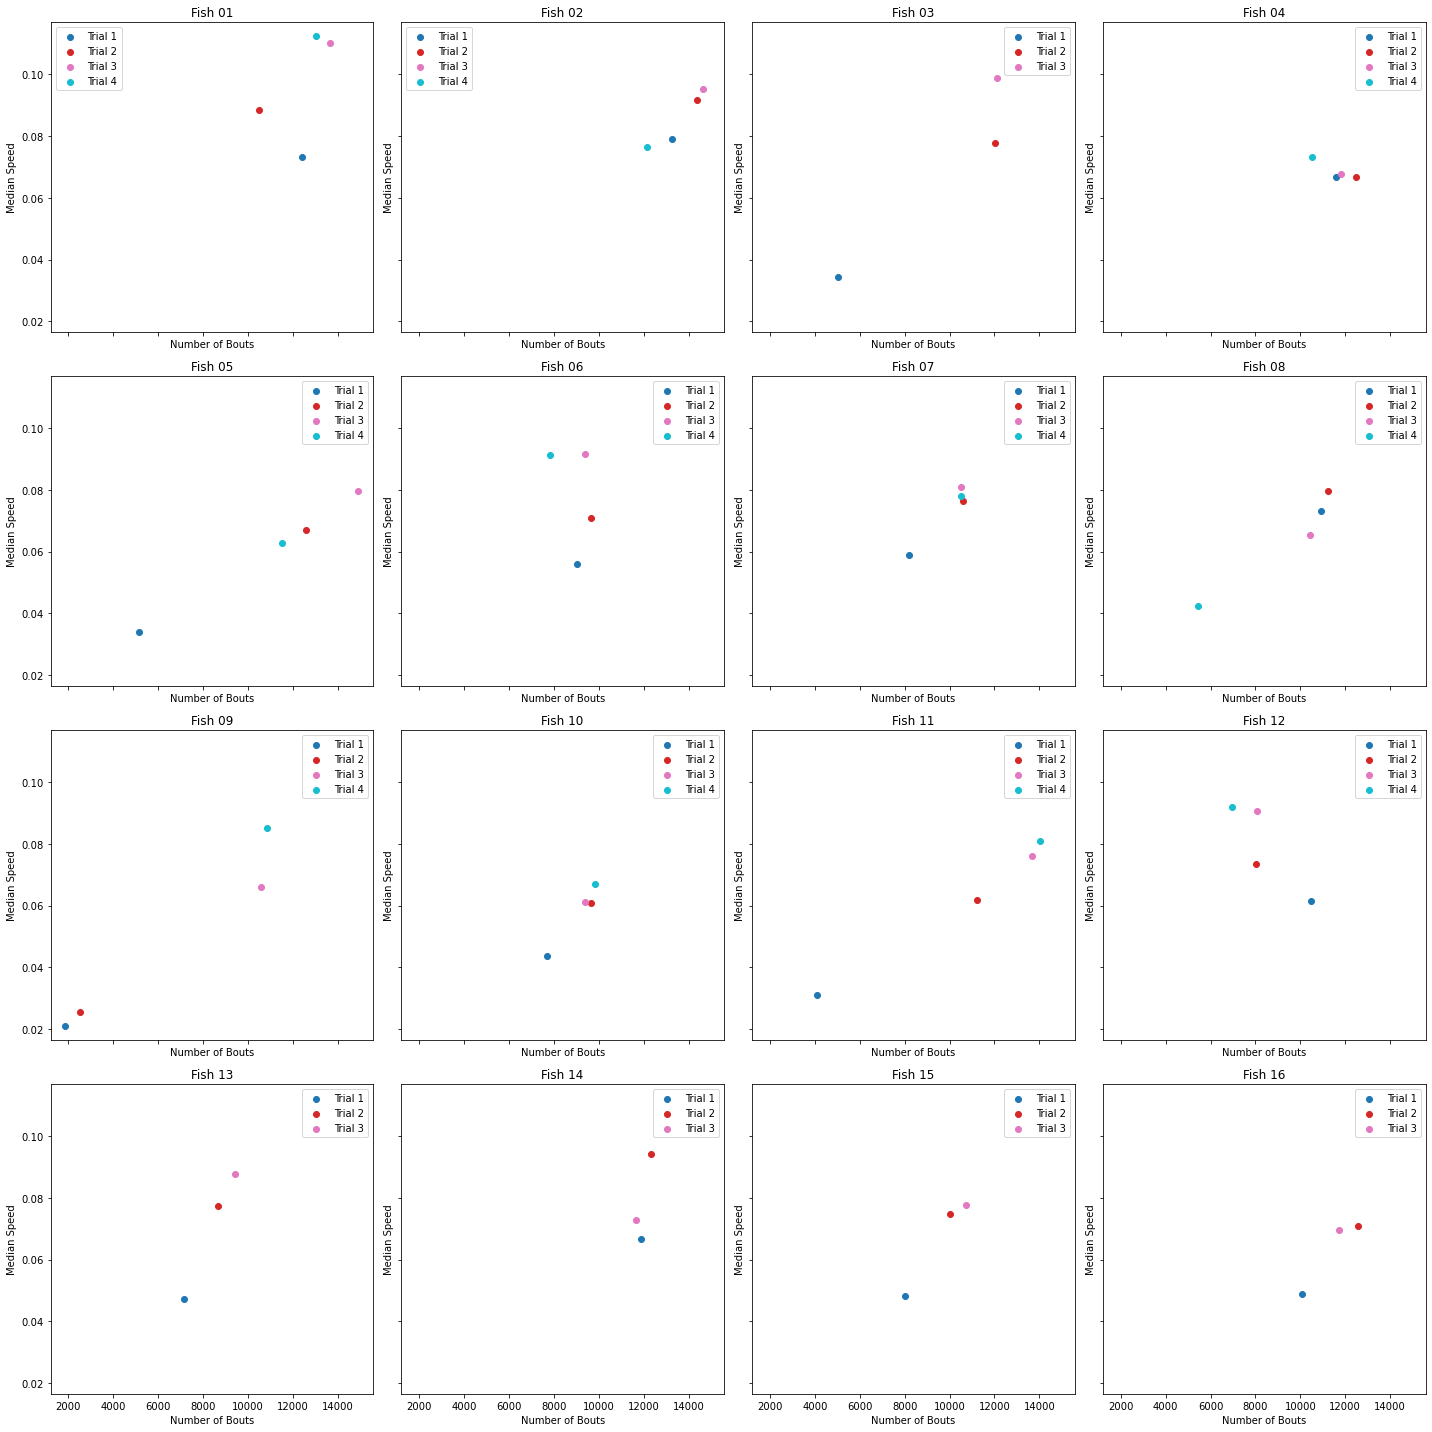

In [9]:
scatter_num_bouts_median_speed_by_fish(fish_data)